# ***Black&White -> color***
Pix2Pix using a GAN



***install kaggle and download dataset***

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

# upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mindmecha","key":"f3054b0ff021b811d25c0b3dfb44ea07"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aayush9753/image-colorization-dataset

 99% 469M/473M [00:05<00:00, 109MB/s]
100% 473M/473M [00:05<00:00, 94.8MB/s]


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip image-colorization-dataset.zip -d "/content/drive/MyDrive/Data_science/image-colorization"

Archive:  image-colorization-dataset.zip
replace /content/drive/MyDrive/Data_science/image-colorization/data/test_black/image5000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# ***Import dataset from drive and modify***

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import PIL
import os
import re
from tqdm import tqdm
import cv2


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  print(gpu)
  tf.config.experimental.set_memory_growth(gpu, True)




PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
train_color_data_path = "/content/drive/MyDrive/Data_science/image-colorization/data/train_color"
test_color_data_path = "/content/drive/MyDrive/Data_science/image-colorization/data/test_color"
train_black_data_path =  "/content/drive/MyDrive/Data_science/image-colorization/data/train_black"
test_black_data_path =  "/content/drive/MyDrive/Data_science/image-colorization/data/test_black"

In [ ]:
SIZE = 256

In [ ]:
color_images = os.listdir(train_color_data_path)
gray_images = os.listdir(train_black_data_path)
color_images_test = os.listdir(test_color_data_path)
gray_images_test = os.listdir(test_black_data_path)

In [ ]:
print(color_images[0], gray_images[0], color_images_test[0], gray_images_test[0])

image3760.jpg image4013.jpg image5189.jpg image5025.jpg


In [ ]:
## as can be seen above the images are not sorted
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

color_images = sorted_alphanumeric(color_images)
gray_images = sorted_alphanumeric(gray_images)
color_images_test = sorted_alphanumeric(color_images_test)
gray_images_test = sorted_alphanumeric(gray_images_test)

In [ ]:
print(color_images[0], gray_images[0], color_images_test[0], gray_images_test[0])

image0000.jpg image0000.jpg image5000.jpg image5000.jpg


In [ ]:
color_images = [os.path.join(train_color_data_path, filename) for filename in color_images]
gray_images = [os.path.join(train_black_data_path, filename) for filename in gray_images]
color_images_test = [os.path.join(test_color_data_path, filename) for filename in color_images_test]
gray_images_test = [os.path.join(test_black_data_path, filename) for filename in gray_images_test]

In [ ]:
print(color_images[0], gray_images[0], color_images_test[0], gray_images_test[0])

/content/drive/MyDrive/Data_science/image-colorization/data/train_color/image0000.jpg /content/drive/MyDrive/Data_science/image-colorization/data/train_black/image0000.jpg /content/drive/MyDrive/Data_science/image-colorization/data/test_color/image5000.jpg /content/drive/MyDrive/Data_science/image-colorization/data/test_black/image5000.jpg


In [ ]:
image_pairs = list(zip(color_images, gray_images))
image_pairs_test = list(zip(color_images_test, gray_images_test))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(image_pairs)
test_ds = tf.data.Dataset.from_tensor_slices(image_pairs_test)

In [ ]:
tr_c_im, tr_b_im = next(iter(train_ds))
ts_c_im, ts_b_im = next(iter(test_ds))

In [ ]:
print(tr_c_im)

tf.Tensor(b'/content/drive/MyDrive/Data_science/image-colorization/data/train_color/image0000.jpg', shape=(), dtype=string)


In [ ]:
def load(color_image_path, gray_image_path):
    color_image = tf.io.read_file(color_image_path)
    color_image = tf.image.decode_jpeg(color_image)
    color_image = tf.cast(color_image, tf.float32)

    gray_image = tf.io.read_file(gray_image_path)
    gray_image = tf.image.decode_jpeg(gray_image)
    gray_image = tf.cast(gray_image, tf.float32)

    return color_image, gray_image

In [ ]:
c_im, g_im = load(tr_c_im, tr_b_im)

(400, 400, 3) (400, 400, 3)


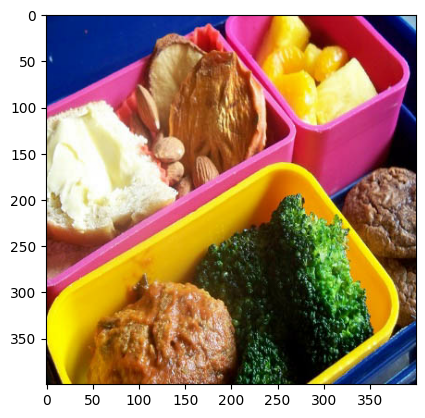

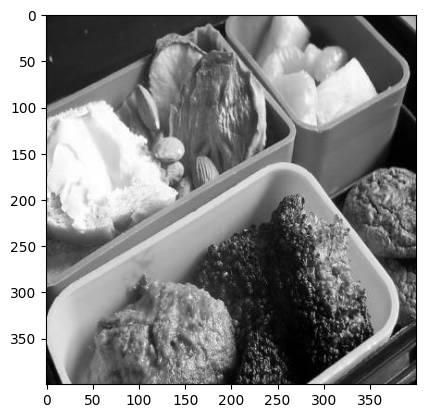

In [ ]:
print(c_im.shape, g_im.shape)
plt.figure()
plt.imshow(c_im/255.0)
plt.figure()
plt.imshow(g_im/255.0)

In [ ]:
ts_cim, ts_bim = load(ts_c_im, ts_b_im)

(400, 400, 3) (400, 400, 3)


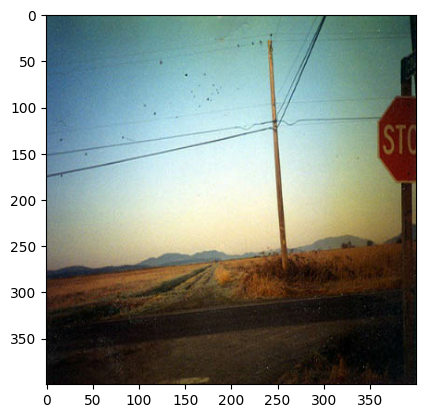

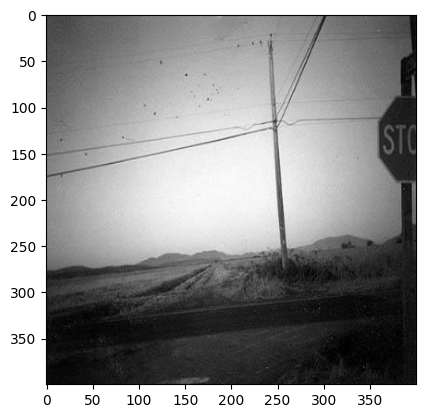

In [ ]:
print(ts_cim.shape, ts_bim.shape)
plt.figure()
plt.imshow(ts_cim/255.0)
plt.figure()
plt.imshow(ts_bim/255.0)

In [ ]:
def resize(color_image, gray_image, SIZE):

    color_image = tf.image.resize(color_image, [SIZE, SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    gray_image = tf.image.resize(gray_image, [SIZE, SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return color_image, gray_image

def normalize(color_image, gray_image):
    color_image = (color_image / 127.5) - 1
    gray_image = (gray_image / 127.5) - 1

    return color_image, gray_image

def apply_preprocess(conc_path):
    color_path = conc_path[0]
    gray_path = conc_path[1]
    color_image, gray_image = load(color_path, gray_path)

    color_image, gray_image = resize(color_image, gray_image, SIZE)
    color_image, gray_image = normalize(color_image, gray_image)

    return color_image, gray_image

In [ ]:
train_bs = 64
test_bs = 8

In [ ]:
train_ds = train_ds.map(apply_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(train_bs)

test_ds = test_ds.map(apply_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(test_bs)

In [ ]:
tr = next(iter(train_ds))
ts = next(iter(test_ds))

In [ ]:
tr_c, tr_g = tr[0], tr[1]
print(tr_c.shape, tr_g.shape)

(64, 256, 256, 3) (64, 256, 256, 3)


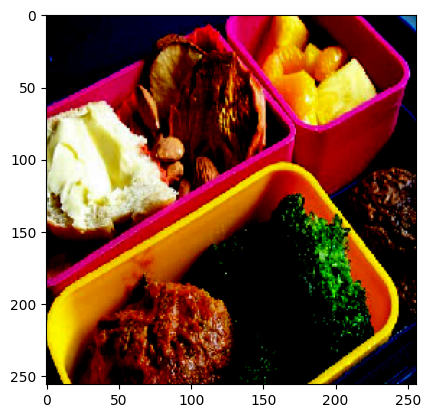

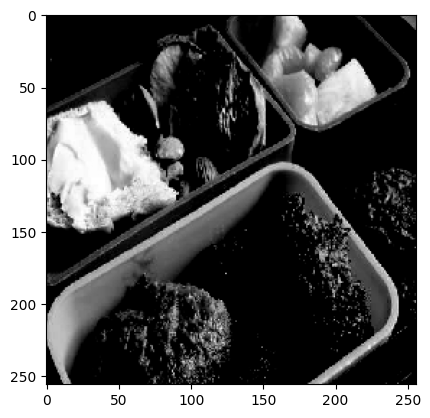

In [ ]:
plt.figure()
plt.imshow(tr_c[0])
plt.figure()
plt.imshow(tr_g[0])

## ***GENERATORS***

In [ ]:
## generators are implemented with U-Net architecure for image translation and processing
### https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/


In [ ]:
!pip install pydot
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
  Running setup.py clean for pygraphviz
Failed to build pygraphviz
ERROR: Could not build wheels for pygraphviz, which is required to install pyproject.toml-based projects


In [ ]:
import pydot
import graphviz

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, Dense, ReLU, Concatenate, Activation

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
gen = generator()

In [ ]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

In [ ]:
!mkdir "/content/drive/MyDrive/Data_science/image-colorization/models"

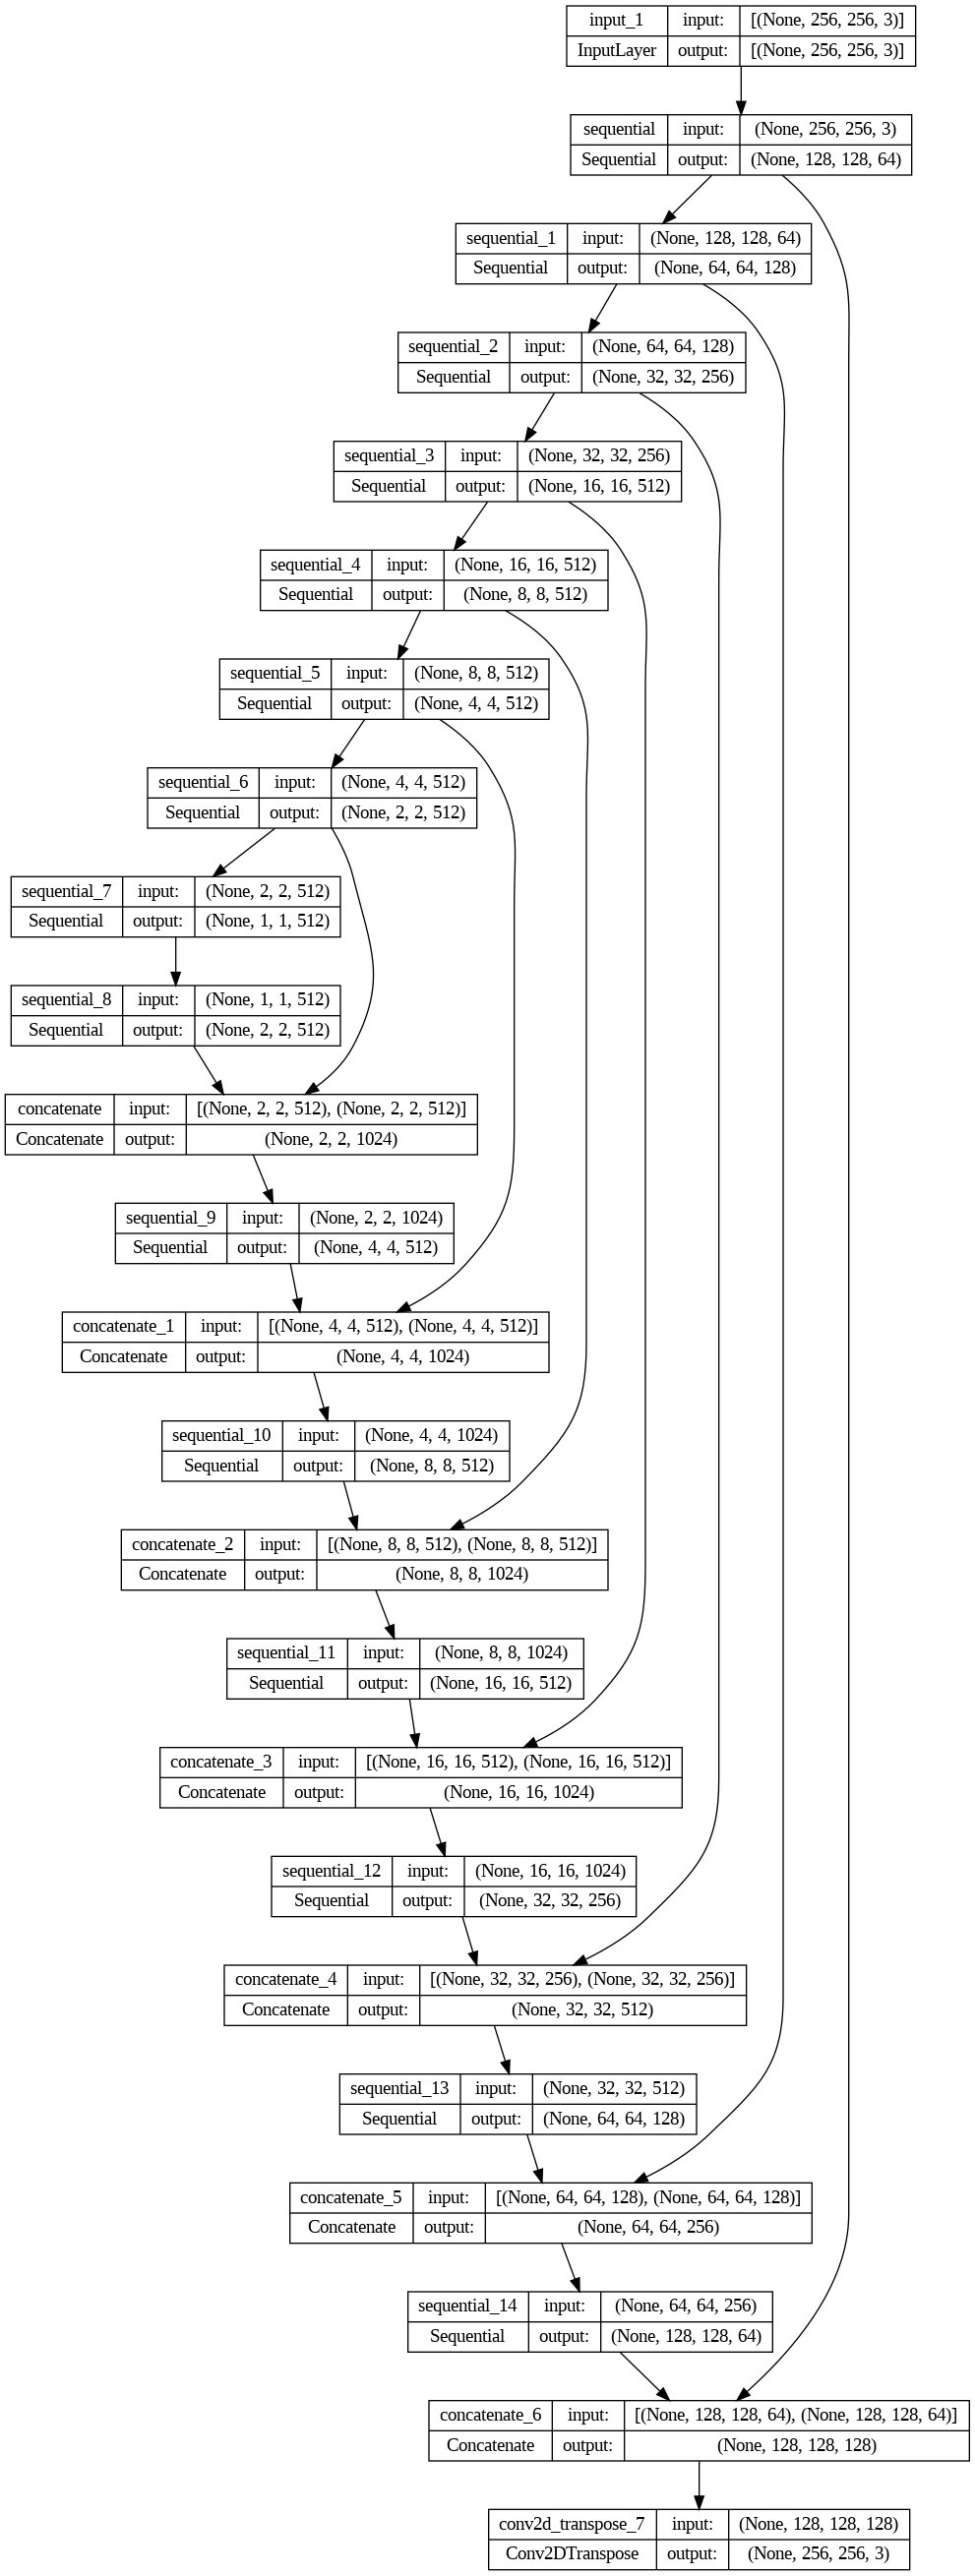

In [ ]:
# plot the model

keras.utils.plot_model(gen, to_file="/content/drive/MyDrive/Data_science/image-colorization/models/base_generator_mmodel.png",
                       show_shapes=True, show_layer_names=True)

In [ ]:
print(tr_g.shape)

(64, 256, 256, 3)


In [ ]:
test_gen_out = gen(tr_g, training=False)

In [ ]:
print(test_gen_out[0].shape)
print(tf.reduce_max(test_gen_out[0]).numpy())

(256, 256, 3)
0.09575971


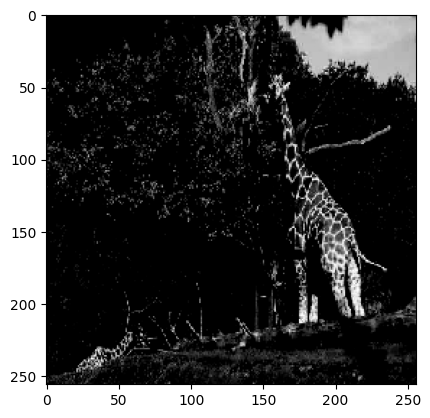

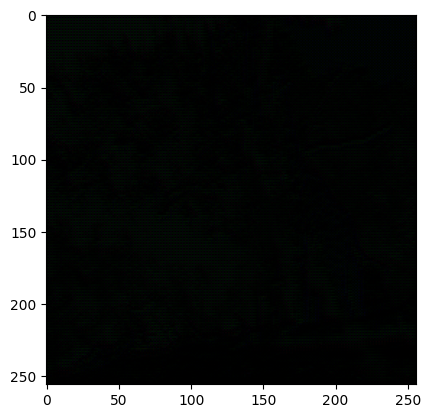

In [ ]:
plt.figure()
plt.imshow(tr_g[1])
plt.figure()
plt.imshow(test_gen_out[1])

# ***Dricriminator***

In [ ]:
## a patch gan implementation of dicriminator model we use a 70x70 filter
### patchGAN : C64-C128-C256-C512,
def discriminator(image_shape):

  ## initialzer
  init = keras.initializers.RandomNormal(stddev=0.02)

  ## input image
  in_img = keras.layers.Input(shape = image_shape)

  ## output image
  out_img = keras.layers.Input(shape=image_shape)

  ## concatenate the two images

  c = Concatenate()([in_img, out_img])

  ## C64
  d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(c)  ## (bs, 128, 128, 62)
  d = LeakyReLU(alpha=0.2)(d)

  ## C128
  d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)  ## (bs, 64, 64, 128)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  ## c256
  d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)  ## (bs, 32, 32, 256)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = keras.layers.ZeroPadding2D()(d) ## (bs, 34, 34, 256)

  ## C512
  d = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(d)  ## (bs, 31, 31, 512)

  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = keras.layers.ZeroPadding2D()(d)  ## (bs, 33, 33, 512)

  ## last layer (path out)
  out = Conv2D(1, 4, strides=1, kernel_initializer=init)(d) # (bs, 30, 30, 1)
  out = Activation('sigmoid')(out)

  model = Model([in_img, out_img], out)

  return model


In [ ]:
image_shape = (256, 256, 3)
dis = discriminator(image_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_2[0][0]',             
 )                                                                   'input_3[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 128, 64)         6208      ['concatenate_7[0][0]'] 

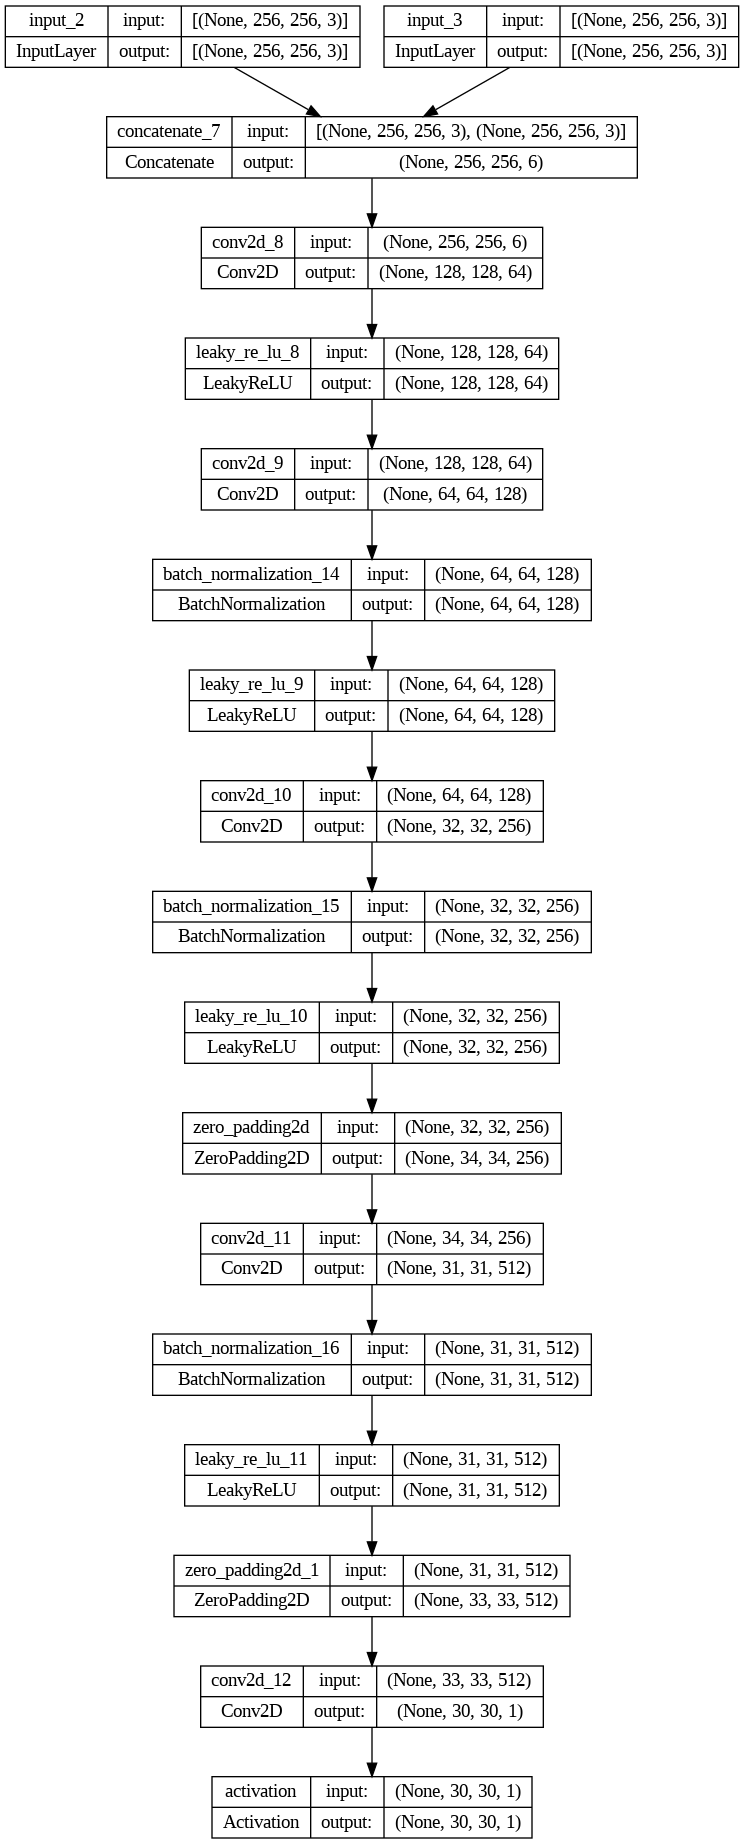

In [ ]:
keras.utils.plot_model(dis, to_file="/content/drive/MyDrive/Data_science/image-colorization/models/base_discriminator_mmodel.png",
                       show_layer_names=True, show_shapes=True)

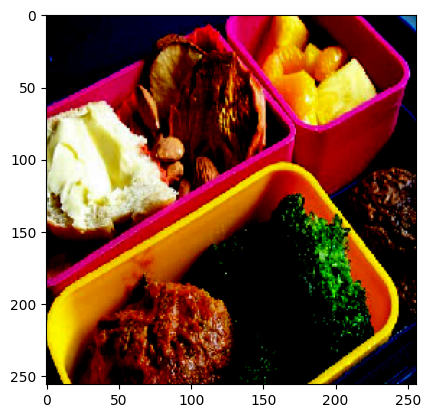

In [ ]:
plt.imshow(tr_c[0])

In [ ]:
print(test_gen_out.shape)

(64, 258, 258, 3)


In [ ]:
test_disc_out = dis([tr_c, test_gen_out], training=False)


In [ ]:
print(test_disc_out.shape)

(64, 30, 30, 1)


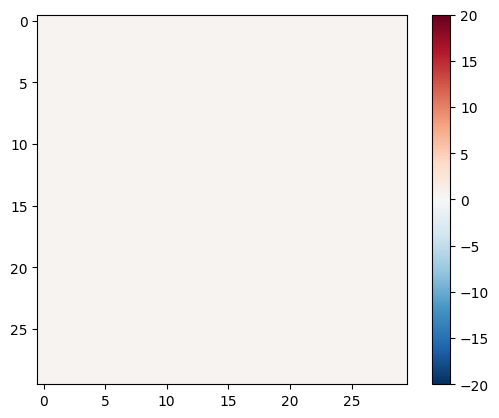

In [ ]:
plt.imshow(test_disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# ***Pix2Pix GAN and losses***

In [ ]:
# the generator loss utilises L1(mae loss) and discriminator loss(that is if the discriminator classsifies it as original or not)

LAMBDA = 100

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, generated_out, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)

    L1_loss = tf.reduce_mean(tf.abs(target-generated_out))

    total_loss = gan_loss + LAMBDA*L1_loss

    return total_loss, gan_loss, L1_loss


In [ ]:
def discriminator_loss(disc_real_output, disc_generate_output):

    real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_obj(tf.zeros_like(disc_generate_output), disc_generate_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
!mkdir "/content/drive/MyDrive/Data_science/image-colorization/check_points"

In [ ]:
## define checkpoints and save the model

checkpoint_dir = "/content/drive/MyDrive/Data_science/image-colorization/check_points"
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoint')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = gen,
                                 discriminator=dis)



# ***Train step and fit***

In [ ]:
import datetime

In [ ]:
log_dir="/content/drive/MyDrive/Data_science/image-colorization/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function()
def train_step(input_image, target, step):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_image = gen(input_image, training=True)

    disc_real_output = dis([input_image, target], training=True)
    disc_generated_output = dis([input_image, gen_image], training=True)

    gen_total_loss, gen_gan_loss, gen_L1_loss = generator_loss(disc_generated_output, gen_image, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, dis.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, dis.trainable_variables))


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_L1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)



In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
import time
from IPython import display

In [ ]:

def fit(train_ds, test_ds, steps):
  example_target, example_input = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
    if (step) % 100 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(gen, example_input, example_target)
      print(f"Step: {step//100}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 500 steps because gpu problem cant train for even 1000 epochs
    if (step + 1) % 500 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

Time taken for 100 steps: 199.97 sec



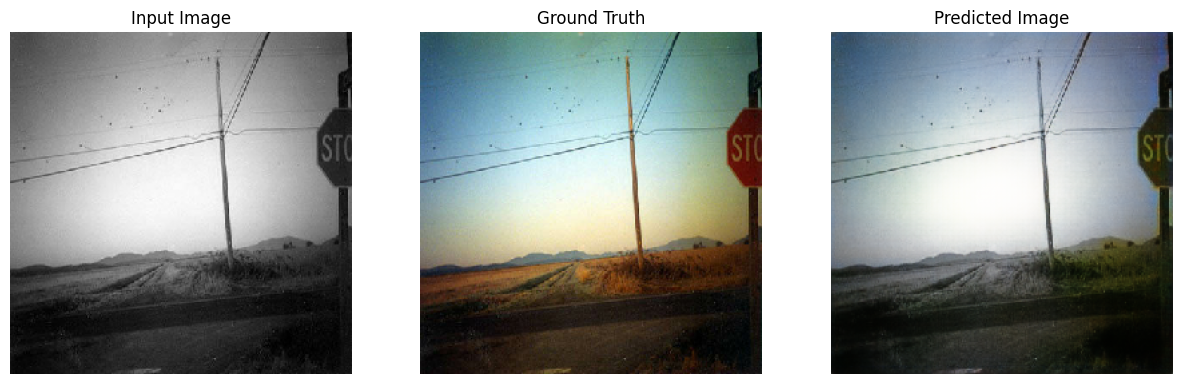

Step: 30k
.

KeyboardInterrupt: ignored

In [ ]:
fit(train_ds, test_ds, 40000)